# overview of llc parcel simulation

In [1]:
import os

import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd

import geopandas as gpd
from shapely.geometry import Polygon

%matplotlib inline
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
import mitequinox.parcels as pa

In [2]:
from dask.distributed import Client, LocalCluster
if True:
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    w = cluster.scale(jobs=2)
else:    
    cluster = LocalCluster()
client = Client(cluster)
client

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.110:8787/status,
Dashboard: http://10.148.0.110:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.110:45279,Workers: 0
Dashboard: http://10.148.0.110:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


---
## load data

In [7]:
#root_dir = '/home1/datawork/aponte/parcels/'
root_dir = os.path.join(ut.work_data_dir, "parcels/")
run_name = 'global_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time'])
df = p.df['time']
df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,waterdepth
time,,,,,,,,,,
2011-11-15 00:00:00,39000000,57.853661,-178.856766,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
2011-11-15 01:00:00,39000000,57.845396,-178.861217,0.0,-0.000003,-2.249167e-06,0.921884,3.915445,32.918678,3749.076904
2011-11-15 02:00:00,39000000,57.838902,-178.874172,0.0,-0.000005,-1.382484e-06,0.987710,3.919090,32.916588,3749.076904
2011-11-15 03:00:00,39000000,57.835855,-178.893247,0.0,-0.000006,-1.862039e-07,0.826575,3.913553,32.917782,3749.076904
2011-11-15 04:00:00,39000000,57.836742,-178.913583,0.0,-0.000005,8.201220e-07,0.475389,3.898716,32.919697,3683.949951


In [8]:
#df['2011-11-15 01:00:00'].compute().head()
# velocities have weird values
# tracers are ok

In [9]:
t_start = df.index.min().compute()
t_end = df.index.max().compute()
delta_t = (t_end - t_start)/pd.Timedelta('1D') # in days

print(t_start, t_end, delta_t)

2011-11-15 00:00:00 2012-11-09 01:00:00 360.0416666666667


### define bins

In [13]:
# geographical bins
dl = 2.
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-90.,90., dl)

# temporal bins
#t_bins = pd.date_range(t_start, t_end, freq='1M')
t_bins = pd.date_range(t_start, t_end, freq='1MS') # starts at the beginning of each month
cut = lambda df, bins: pd.cut(df.index.to_series(), bins=bins)

In [14]:
df['lon'] = (df['lon']+180)%360 - 180
df['lon_cut'] = df['lon'].map_partitions(pd.cut, lon_bins)
df['lat_cut'] = df['lat'].map_partitions(pd.cut, lat_bins)
df['time_cut'] = df.map_partitions(cut, t_bins)

In [15]:
df = df.persist()

### group by geographical area

In [22]:
def add_geodata(df):

    df['lon'] = df.apply(lambda r: r.name[0].mid, axis=1)
    df['lat'] = df.apply(lambda r: r.name[1].mid, axis=1)

    def build_polygon(r):
        lon0, lon1 = r.name[0].left, r.name[0].right
        lat0, lat1 = r.name[1].left, r.name[1].right
        return Polygon([[lon0, lat0],[lon1, lat0], [lon1, lat1], [lon0, lat1]])

    df['Coordinates'] = df.apply(build_polygon, axis=1)
    df = gpd.GeoDataFrame(df, geometry='Coordinates', crs='EPSG:4326')
    df['area'] = df.to_crs(crs = 'epsg:3857').area /1e6 / 1e4 # 100km^2 units
    
    return df

In [23]:
count = (df
         .groupby([df.lon_cut, df.lat_cut])
         .count()
         .compute()
         ['z'].rename('count')
         .to_frame()
        )

# normalize by time window length
count = count/delta_t
#
count = add_geodata(count)
count['density'] = count['count']/count['area']

ds = (count
      .drop(columns=['Coordinates'])
      .set_index(['lon', 'lat'])
      .to_xarray()
     )

Text(0.5, 1.0, 'Average number of floats per 100km^2 and per day')

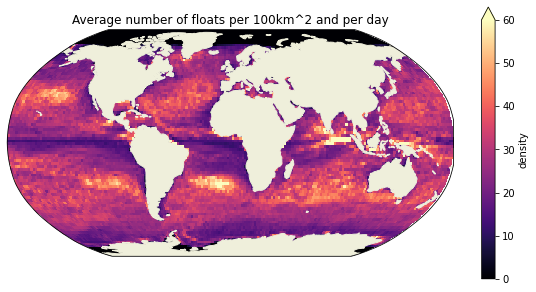

In [24]:
figsize = (10,5)

#crs = ccrs.Mollweide()
crs = ccrs.Robinson()
#crs = ccrs.EqualEarth()
#crs = ccrs.Geodetic()

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=crs)

ds['density'].plot(x='lon', 
                 y='lat',
                 vmax=60,
                 cmap='magma',
                 ax=ax,
                 transform=ccrs.PlateCarree(),
                )

ax.add_feature(cfeature.LAND, zorder=1)

ax.set_title('Average number of floats per 100km^2 and per day')

Text(0.5, 1.0, 'Average number of floats per 100km^2 and per day')

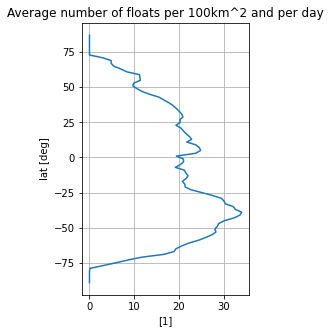

In [25]:
# zonal mean
ds_zmean = (ds.density*ds.area).sum('lon') / ds.area.sum('lon')

fig, ax = plt.subplots(1,1, figsize=(3,5))

ax.plot(ds_zmean,ds_zmean.lat)
ax.set_xlabel('[1]')
ax.set_ylabel('lat [deg]')
ax.grid()
ax.set_title('Average number of floats per 100km^2 and per day')

---
## group by month

In [26]:
count = (df
         .groupby('time_cut')
         .count()['z']
         .compute()
         .rename('count')
         .to_frame()
        )
count['time'] = count.index.to_series().apply(lambda d: d.left)
count = count.set_index('time')
count = count/30 # normalize per number of days

Text(0.5, 1.0, 'data points per day')

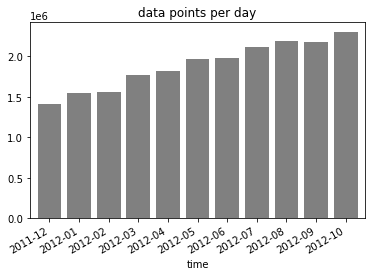

In [27]:
fig, ax = plt.subplots()
#count['time'] = count.index.to_series().apply(lambda d: d.left)
count['count'].plot.bar(ax=ax, width=.8, color='0.5')
ax.set_xticklabels([pd.Timestamp(t.get_text()).strftime('%Y-%m') 
                    for t in ax.get_xticklabels()
                   ])
fig.autofmt_xdate()
ax.set_title('data points per day')

Text(0.5, 1.0, 'number of drifters')

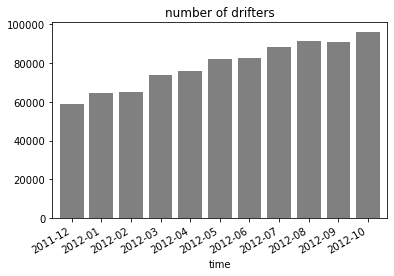

In [29]:
fig, ax = plt.subplots()
#count['time'] = count.index.to_series().apply(lambda d: d.left)
(count['count']/24).astype(int).plot.bar(ax=ax, width=.8, color='0.5')
ax.set_xticklabels([pd.Timestamp(t.get_text()).strftime('%Y-%m') 
                    for t in ax.get_xticklabels()
                   ])
fig.autofmt_xdate()
ax.set_title('number of drifters')

---
### group by geographical area and month

In [30]:
count = (df
         .groupby([df.lon_cut, df.lat_cut, df.time_cut])
         .count()['z']
         .compute()
         .rename('count')
         .to_frame()
        )
count = count/30 # normalize per number of days

count['time'] = count.index.to_series().apply(lambda v: v[2].left)

count = add_geodata(count)

ds = (count
      .drop(columns=['Coordinates'])
      .set_index(['lon', 'lat', 'time'])
      .to_xarray()
     )

ds['density'] = ds['count']/ds['area']

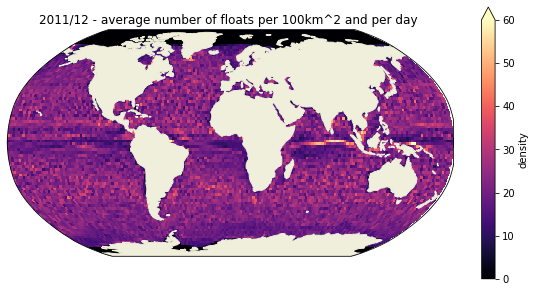

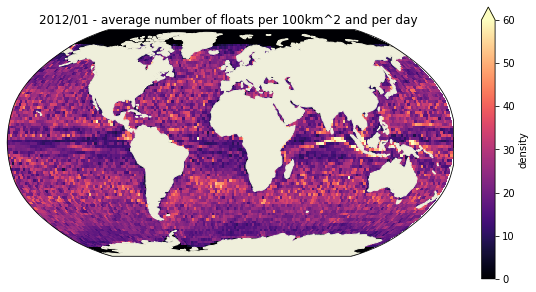

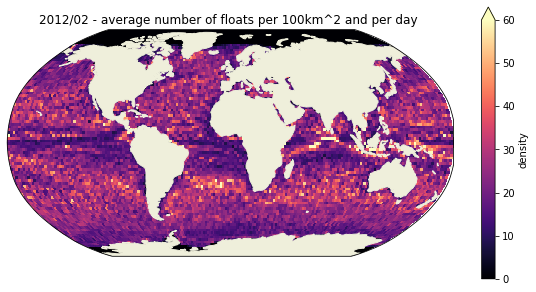

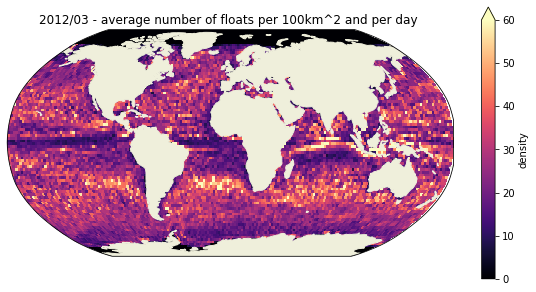

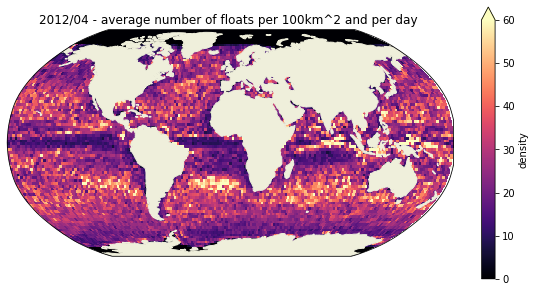

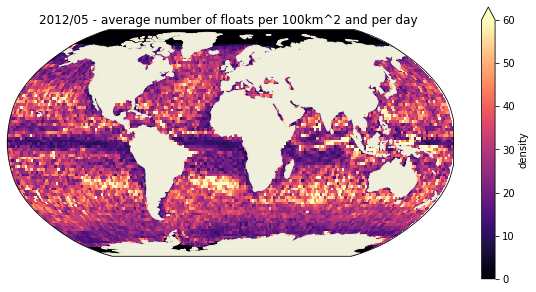

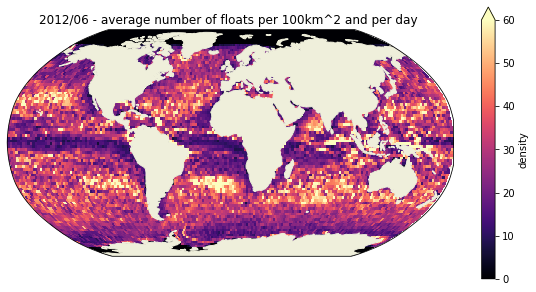

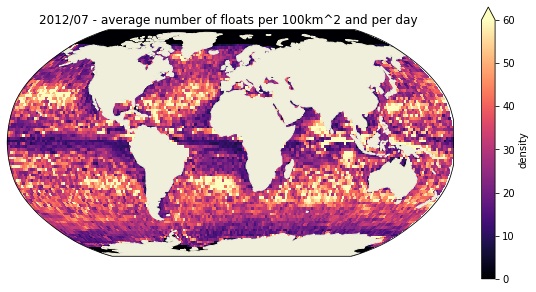

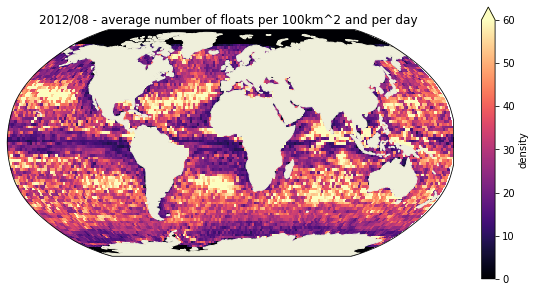

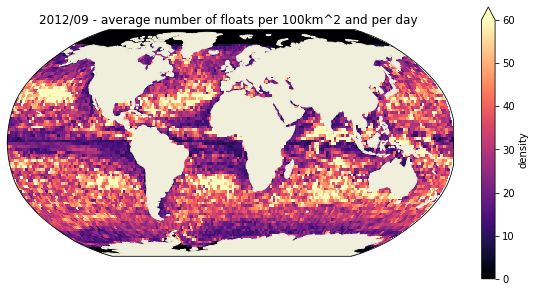

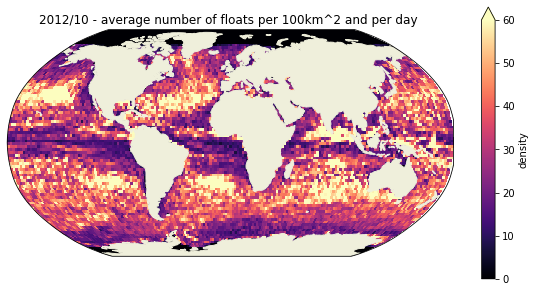

In [31]:
figsize = (10,5)

for t in ds.time:
    
    _ds = ds.sel(time=t)
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection=crs)

    _ds['density'].plot(x='lon', 
                     y='lat',
                     vmax=60,
                     cmap='magma',
                     ax=ax,
                     transform=ccrs.PlateCarree(),
                    )

    #ax.add_feature(cfeature.LAND.with_scale('110m'))
    ax.add_feature(cfeature.LAND, zorder=1)

    ax.set_title('{} - average number of floats per 100km^2 and per day '.format(t.dt.strftime('%Y/%m').values))

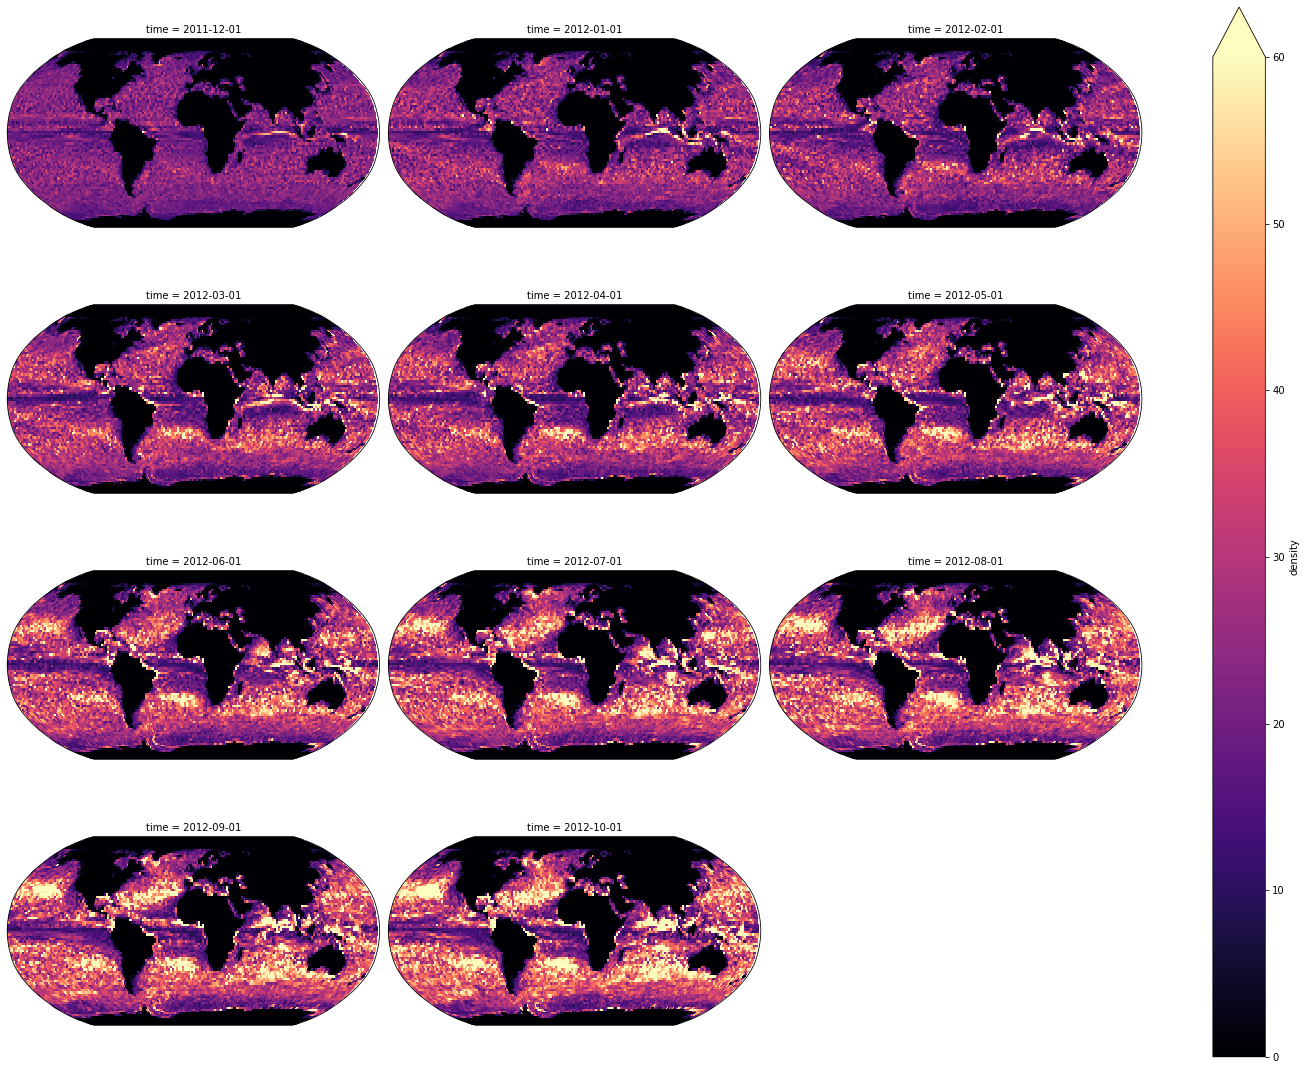

In [32]:
# land cannot be shown ...
ds['density'].plot(x='lon', 
                   y='lat',
                   col='time',
                   col_wrap=3,
                   vmax=60,
                   cmap='magma',
                   transform=ccrs.PlateCarree(),
                   subplot_kws={'projection':crs},
                   figsize=(20,15),
                  )

Text(0.5, 1.0, 'First time without float in 2.0deg x 2.0deg boxes')

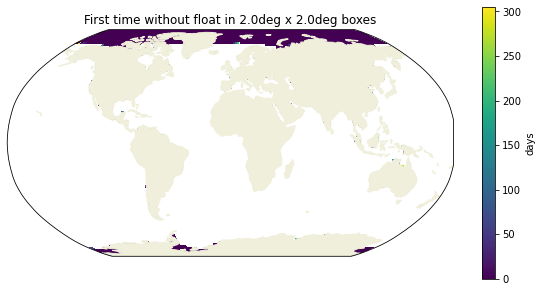

In [33]:
day_no_float = (ds.density.where(ds.density==0).idxmax('time') - ds.time.min()).dt.days

figsize = (10,5)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=crs)

day_no_float.plot(x='lon', 
                 y='lat',
                 cmap='viridis',
                 ax=ax,
                 transform=ccrs.PlateCarree(),
                )

#ax.add_feature(cfeature.LAND.with_scale('110m'))
ax.add_feature(cfeature.LAND, zorder=1)

ax.set_title('First time without float in {}deg x {}deg boxes'.format(dl,dl))

---

## store reduced dataset for Jinbo

In [17]:
df_small = df.loc[:, ["trajectory", "lon", "lat"]]
df_small.head()

,trajectory,lon,lat
time,,,
2011-11-15 00:00:00,39000000,-178.856766,57.853661
2011-11-15 01:00:00,39000000,-178.861217,57.845396
2011-11-15 02:00:00,39000000,-178.874172,57.838902
2011-11-15 03:00:00,39000000,-178.893247,57.835855
2011-11-15 04:00:00,39000000,-178.913583,57.836742


In [21]:
pa.store_parquet(ut.scratch, 
                 df_small, 
                 index='time', 
                 name="llc4320_lagrangian", 
                 overwrite=True,
                )

create new archive: /home1/scratch/aponte/llc4320_lagrangian


'/home1/scratch/aponte/llc4320_lagrangian'

## Close cluster

In [35]:
cluster.close()